In [1]:
import skimage
import tifffile
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from scipy.optimize import curve_fit
from matplotlib import rcParams
from statsmodels.stats.weightstats import ttest_ind
from statannotations.Annotator import Annotator
rcParams['figure.dpi'] = 250
plt.rcParams['figure.figsize'] = (20, 10)
plt.rcParams['font.size'] = 20

In [2]:
class Plate():

    def __init__(self, data_dir, analysis_name):
        self.data_dir = data_dir
        self.analysis_name = analysis_name
        self._load_data()
        self._load_platemap()

    def _load_data(self):
            
        self.image_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                (self.analysis_name + 'Image.csv'))
        self.soma_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                (self.analysis_name + 'cytoplasm_outlines.csv'))
        self.nuclei_data = pd.read_csv(self.data_dir / 
                                self.analysis_name /
                                (self.analysis_name + 'nuclei.csv'))
    
    def _load_platemap(self):
        self.platemap = pd.read_csv(self.data_dir / 'platemap.csv') 
        

In [3]:
def calculate_ratio(plate, measurement):

    ratio_data = pd.DataFrame(index = plate.soma_data.index)

    # Set filename and well position
    ratio_data['FileName_TDP43'] = plate.soma_data['FileName_TDP43']
    ratio_data['well_position'] = ratio_data['FileName_TDP43'].apply(
        lambda fname : chr(int(fname[1:3])+64) + fname[4:6]
    )
    ratio_data['row'] = ratio_data['FileName_TDP43'].apply(
    lambda fname : int(fname[1:3])
    )
    ratio_data['col'] = ratio_data['FileName_TDP43'].apply(
        lambda fname : int(fname[4:6])
    )

    # Get mean TDP43 in nucleus
    ratio_data['TDP43_nucleus'] = (
        plate.nuclei_data[measurement] / 
        plate.nuclei_data['AreaShape_Area']
        )

    # Get mean TDP43 in cytoplasm, subtracting out nucleus first
    ratio_data['TDP43_cytoplasm'] = (
        (plate.soma_data[measurement] - 
        plate.nuclei_data[measurement]) /  
        (plate.soma_data['AreaShape_Area'] - 
        plate.nuclei_data['AreaShape_Area'])
    )

    # Get ratio of cytoplasm / nucleus
    ratio_data['TDP43_ratio'] = (
        ratio_data['TDP43_cytoplasm'] / 
        ratio_data['TDP43_nucleus']
    )
    return ratio_data


In [4]:
def sigmoid(x, a, b, c):
     y = 1 / (1 + np.exp(-b*(x-a)))
     return y + c

/tmp/ipykernel_3365/2301750927.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_DDX39B vs. 2_No Nucleofection: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=1.275e+00
0_DDX39B vs. 0_No Nucleofection: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-9.504e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

2_DECR2 vs. 2_No Nucleofection: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-1.111e+00
0_DECR2 vs. 0_No Nucleofection: t-test independent samples with Bonferroni correction, P_val:4.863e-01 t=1.983e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.0

/tmp/ipykernel_3365/2301750927.py:31: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
/home/ubuntu/miniconda3/envs/cell-imaging-2/lib/python3.8/site-packages/seaborn/categorical.py:292: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  sub_data.loc[:, self.cat_axis] = adjusted_data
/home/ubuntu/miniconda3/envs/cell-imaging-2/lib/python3.8/site-packages/seaborn/categorical.py:292: FutureWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead 

ValueError: Missing hue value `DDX39B` in crispr (specified in `pairs`)

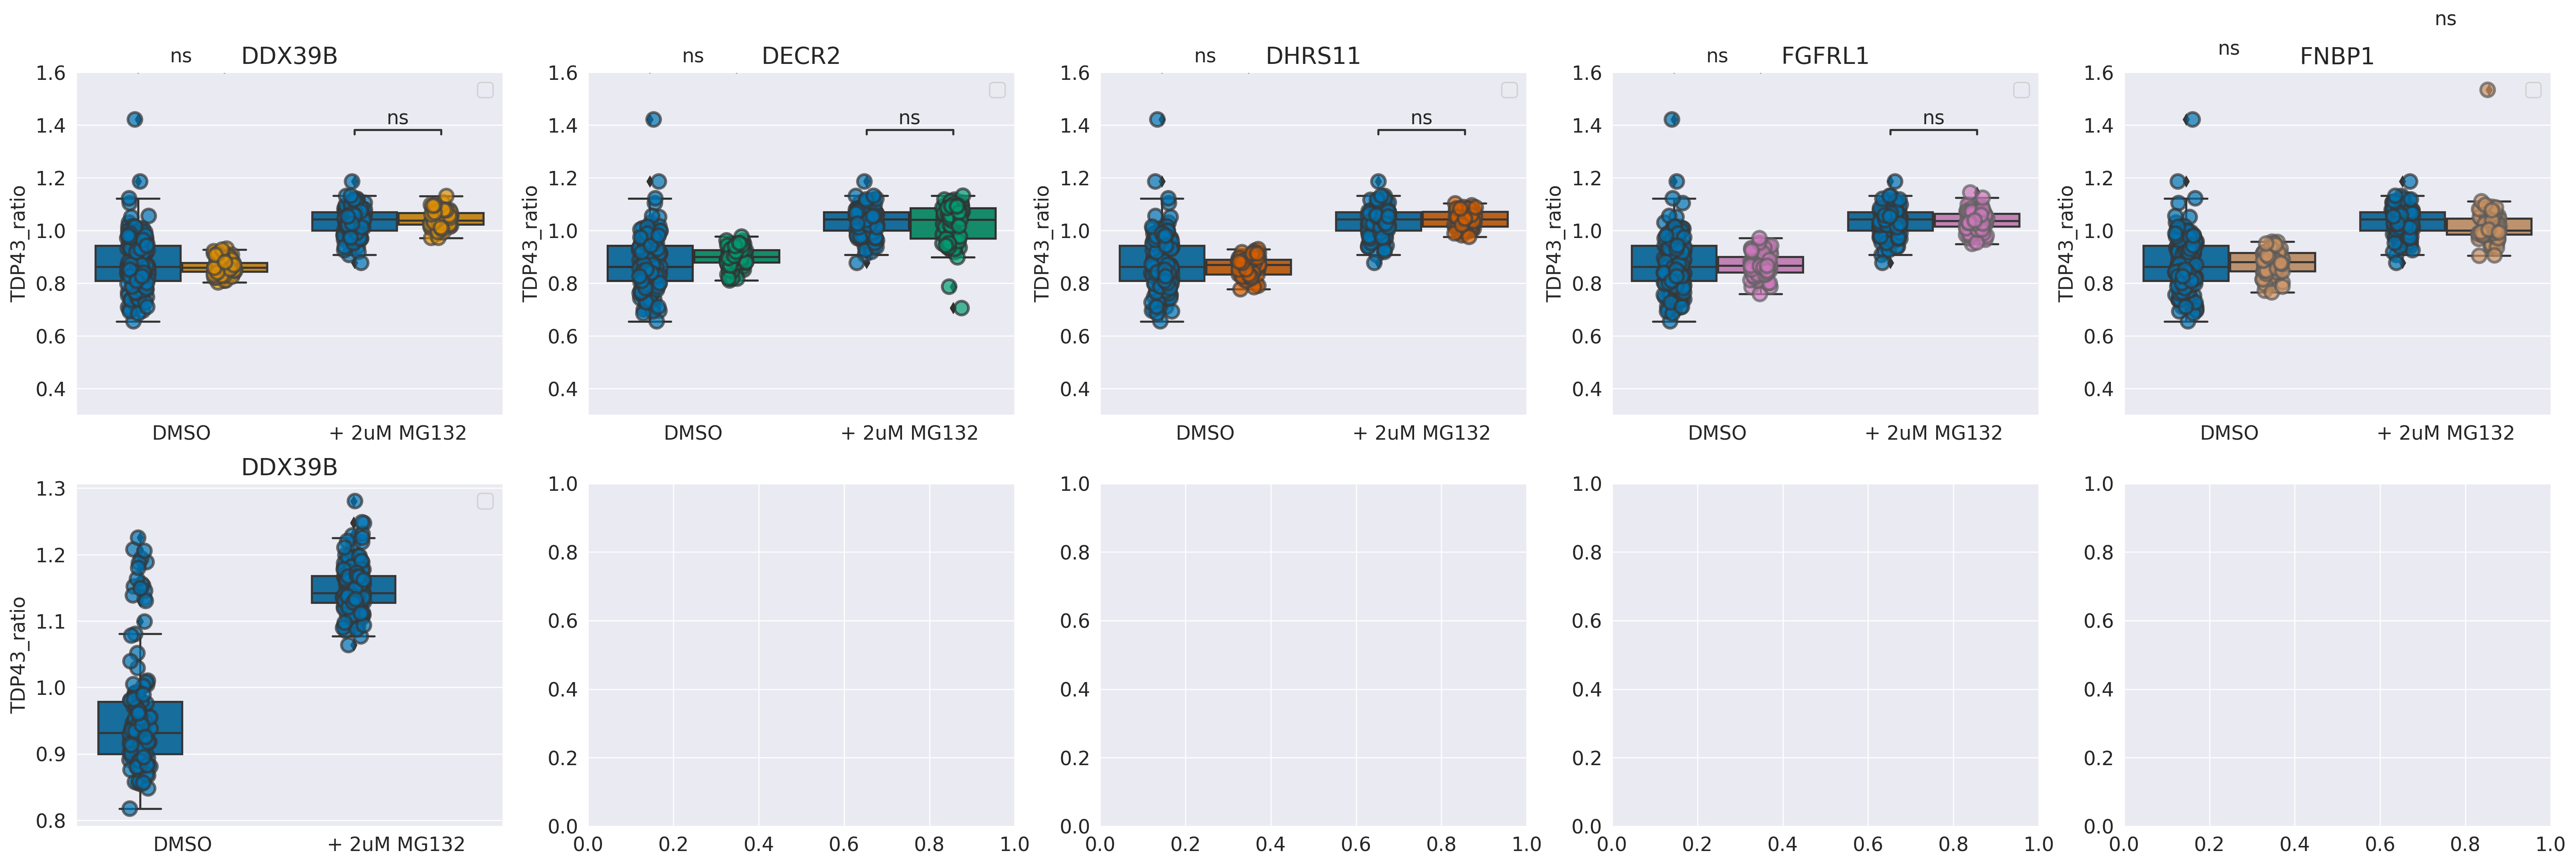

In [8]:
# dirs = [Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1'),
#     Path('/lab/processed-data/ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1'),
#     Path('/lab/processed-data/ALS0006_KO01_TDP43_20X/ALS0006_KO01_TDP43_20X_01__2023-03-08T11_11_56-Measurement 1/')]

dirs = [Path('/lab/processed-data/TDP43_ALS0009_DIV18_KO_MG132/TDP43_ALS0009_KO1_DIV18_v1__2023-03-14T10_55_23-Measurement 1'),
    Path('/lab/processed-data/TDP43_ALS0013_DIV11_KO_MG132/DIV11 v1__2023-03-15T09_33_32-Measurement 1/')]

analysis_name = '2023-02-17_tdp43seg_tdp-43'
measurement = 'Intensity_IntegratedIntensity_TDP43_corrected'

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (32, 10)
plt.rcParams['font.size'] = 14
NT_color = sns.color_palette('colorblind')[0]
ylims = [[0.3, 1.6], [0.5, 1.8], [0.4, 2]]
# crispr_mutants = ratio_data.query('crispr not in["empty", "NT"]')['crispr'].unique()
# crispr_mutants = ['UNC13A', 'C9ORF72', 'SCFD1', 'RANBP10', 'ZDHHC6', 'ZNF142',
#        'RESP18']
crispr_mutants = ['ALG8', 'AP3B2', 'BAG6',
       'C2CD4A', 'CAMLG', 'CLCN3', 'COG3']
crispr_mutants = ['DDX39B', 'DECR2', 'DHRS11', 'FGFRL1', 'FNBP1']
fig, axs = plt.subplots(len(dirs), len(crispr_mutants))

for i_exp, data_dir in enumerate(dirs[::-1]):
    plate = Plate(data_dir, analysis_name)
    ratio_data = calculate_ratio(plate, measurement)
    ratio_data = ratio_data.merge(plate.platemap, on='well_position')
    ratio_data['concentration'] = '0'
    ratio_data.loc[ratio_data['row'] >= 5, 'treatment'] = 'MG132'
    ratio_data.loc[ratio_data['row'] >= 5, 'concentration'] = '2'
    ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
    # ratio_data = ratio_data.groupby(['well_position', 'crispr', 'treatment', 'concentration']).mean()
    ratio_data = ratio_data.reset_index()
    ratio_data = ratio_data.drop(ratio_data.index[ratio_data['TDP43_ratio'] > 2])

    # crispr_mutants = ratio_data['crispr'].unique()
    # pairs = [[(('0', 'NT'), ('0', crispr)), (('2', 'NT'), ('2', crispr))][0] for crispr in crispr_mutants]
    for i_crispr, crispr in enumerate(crispr_mutants):

        data = ratio_data.query('crispr in ["No Nucleofection", @crispr] and concentration in ["0", "2"]')
        hue = 'crispr'
        x = 'concentration'
        y = 'TDP43_ratio'
        ax = axs[i_exp,i_crispr]
        crispr_color = sns.color_palette('colorblind')[i_crispr+1]
        hue_order = ['No Nucleofection', crispr]
        sns.boxplot(ax=ax,data=data, x=x, y=y, hue=hue, hue_order=hue_order, palette=[NT_color, crispr_color])
        sns.stripplot(ax=ax,data=data, x=x, y=y, hue=hue,  hue_order=hue_order, dodge=True, linewidth=2, size=10, palette=[NT_color, crispr_color], alpha=0.7)
        ax.set_xticklabels(['DMSO', '+ 2uM MG132'])
        ax.set_xlabel('')
        ax.legend([])
        ax.set_title(crispr)

        pairs = [(('0', 'No Nucleofection'), ('0', crispr)), (('2', 'No Nucleofection'), ('2', crispr))]
        annot = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue)
        annot.configure(test='t-test_ind', text_format='star',  comparisons_correction='bonferroni')
        annot.apply_test(num_comparisons=len(crispr_mutants)*2)
        ax, test_results = annot.annotate(line_offset_to_group=0.2)
        ax.set_ylim(ylims[i_exp])

plt.subplots_adjust(wspace=0.3, hspace=0.3)
axs[0,0].set_ylabel('DIV11')
axs[1,0].set_ylabel('DIV18')

In [24]:
ratio_data

FileName_TDP43            crispr treatment  \
0     r02c02f01p01-ch2sk1fk1fl1.tiff  No Nucleofection     empty   
1     r02c02f02p01-ch2sk1fk1fl1.tiff  No Nucleofection     empty   
2     r02c02f03p01-ch2sk1fk1fl1.tiff  No Nucleofection     empty   
3     r02c02f04p01-ch2sk1fk1fl1.tiff  No Nucleofection     empty   
4     r02c02f05p01-ch2sk1fk1fl1.tiff  No Nucleofection     empty   
...                              ...               ...       ...   
1435  r07c11f20p01-ch2sk1fk1fl1.tiff  No Nucleofection     MG132   
1436  r07c11f21p01-ch2sk1fk1fl1.tiff  No Nucleofection     MG132   
1437  r07c11f22p01-ch2sk1fk1fl1.tiff  No Nucleofection     MG132   
1438  r07c11f23p01-ch2sk1fk1fl1.tiff  No Nucleofection     MG132   
1439  r07c11f24p01-ch2sk1fk1fl1.tiff  No Nucleofection     MG132   

     concentration  row   col  TDP43_nucleus  TDP43_cytoplasm  TDP43_ratio  \
0                0  2.0   2.0       0.008283         0.009490     1.153046   
1                0  2.0   2.0       0.008706         0.009733     1.134221   
2                0  2.0   2.0       0.008165         0.008766     1.080494   
3                0  2.0   2.0       0.008148              NaN          NaN   
4                0  2.0   2.0       0.008224              NaN          NaN   
...            ...  ...   ...            ...              ...          ...   
1435             2  7.0  11.0       0.164288         0.180007     1.125758   
1436             2  7.0  11.0       0.161086         0.177167     1.127888   
1437             2  7.0  11.0       0.136997         0.150969     1.132492   
1438             2  7.0  11.0       0.147091         0.163394     1.161848   
1439             2  7.0  11.0       0.130875         0.141698     1.111354   

       QC  
0     1.0  
1     1.0  
2     1.0  
3     1.0  
4     1.0  
...   ...  
1435  1.0  
1436  1.0  
1437  1.0  
1438  1.0  
1439  1.0  

[1440 rows x 10 columns]

/tmp/ipykernel_3365/2788827177.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.25_UNC13A vs. 0.25_NT: t-test independent samples with Bonferroni correction, P_val:8.930e-02 t=-2.858e+00
0_UNC13A vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=1.462e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.25_C9ORF72 vs. 0.25_NT: t-test independent samples with Bonferroni correction, P_val:3.222e-03 t=3.997e+00
0_C9ORF72 vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:8.826e-01 t=1.877e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.25_SCFD1 vs. 0.25_NT: t-test ind

/tmp/ipykernel_3365/2788827177.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.25_UNC13A vs. 0.25_NT: t-test independent samples with Bonferroni correction, P_val:6.472e-06 t=-5.864e+00
0_UNC13A vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=5.518e-02
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.25_C9ORF72 vs. 0.25_NT: t-test independent samples with Bonferroni correction, P_val:1.248e-06 t=6.341e+00
0_C9ORF72 vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=9.185e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.25_SCFD1 vs. 0.25_NT: t-test ind

/tmp/ipykernel_3365/2788827177.py:23: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()


p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.25_UNC13A vs. 0.25_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-1.662e+00
0_UNC13A vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=7.734e-01
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.25_C9ORF72 vs. 0.25_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-1.115e+00
0_C9ORF72 vs. 0_NT: t-test independent samples with Bonferroni correction, P_val:1.000e+00 t=-1.243e+00
p-value annotation legend:
      ns: p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

0.25_SCFD1 vs. 0.25_NT: t-test i

Text(884.3055555555555, 0.5, 'DIV25')

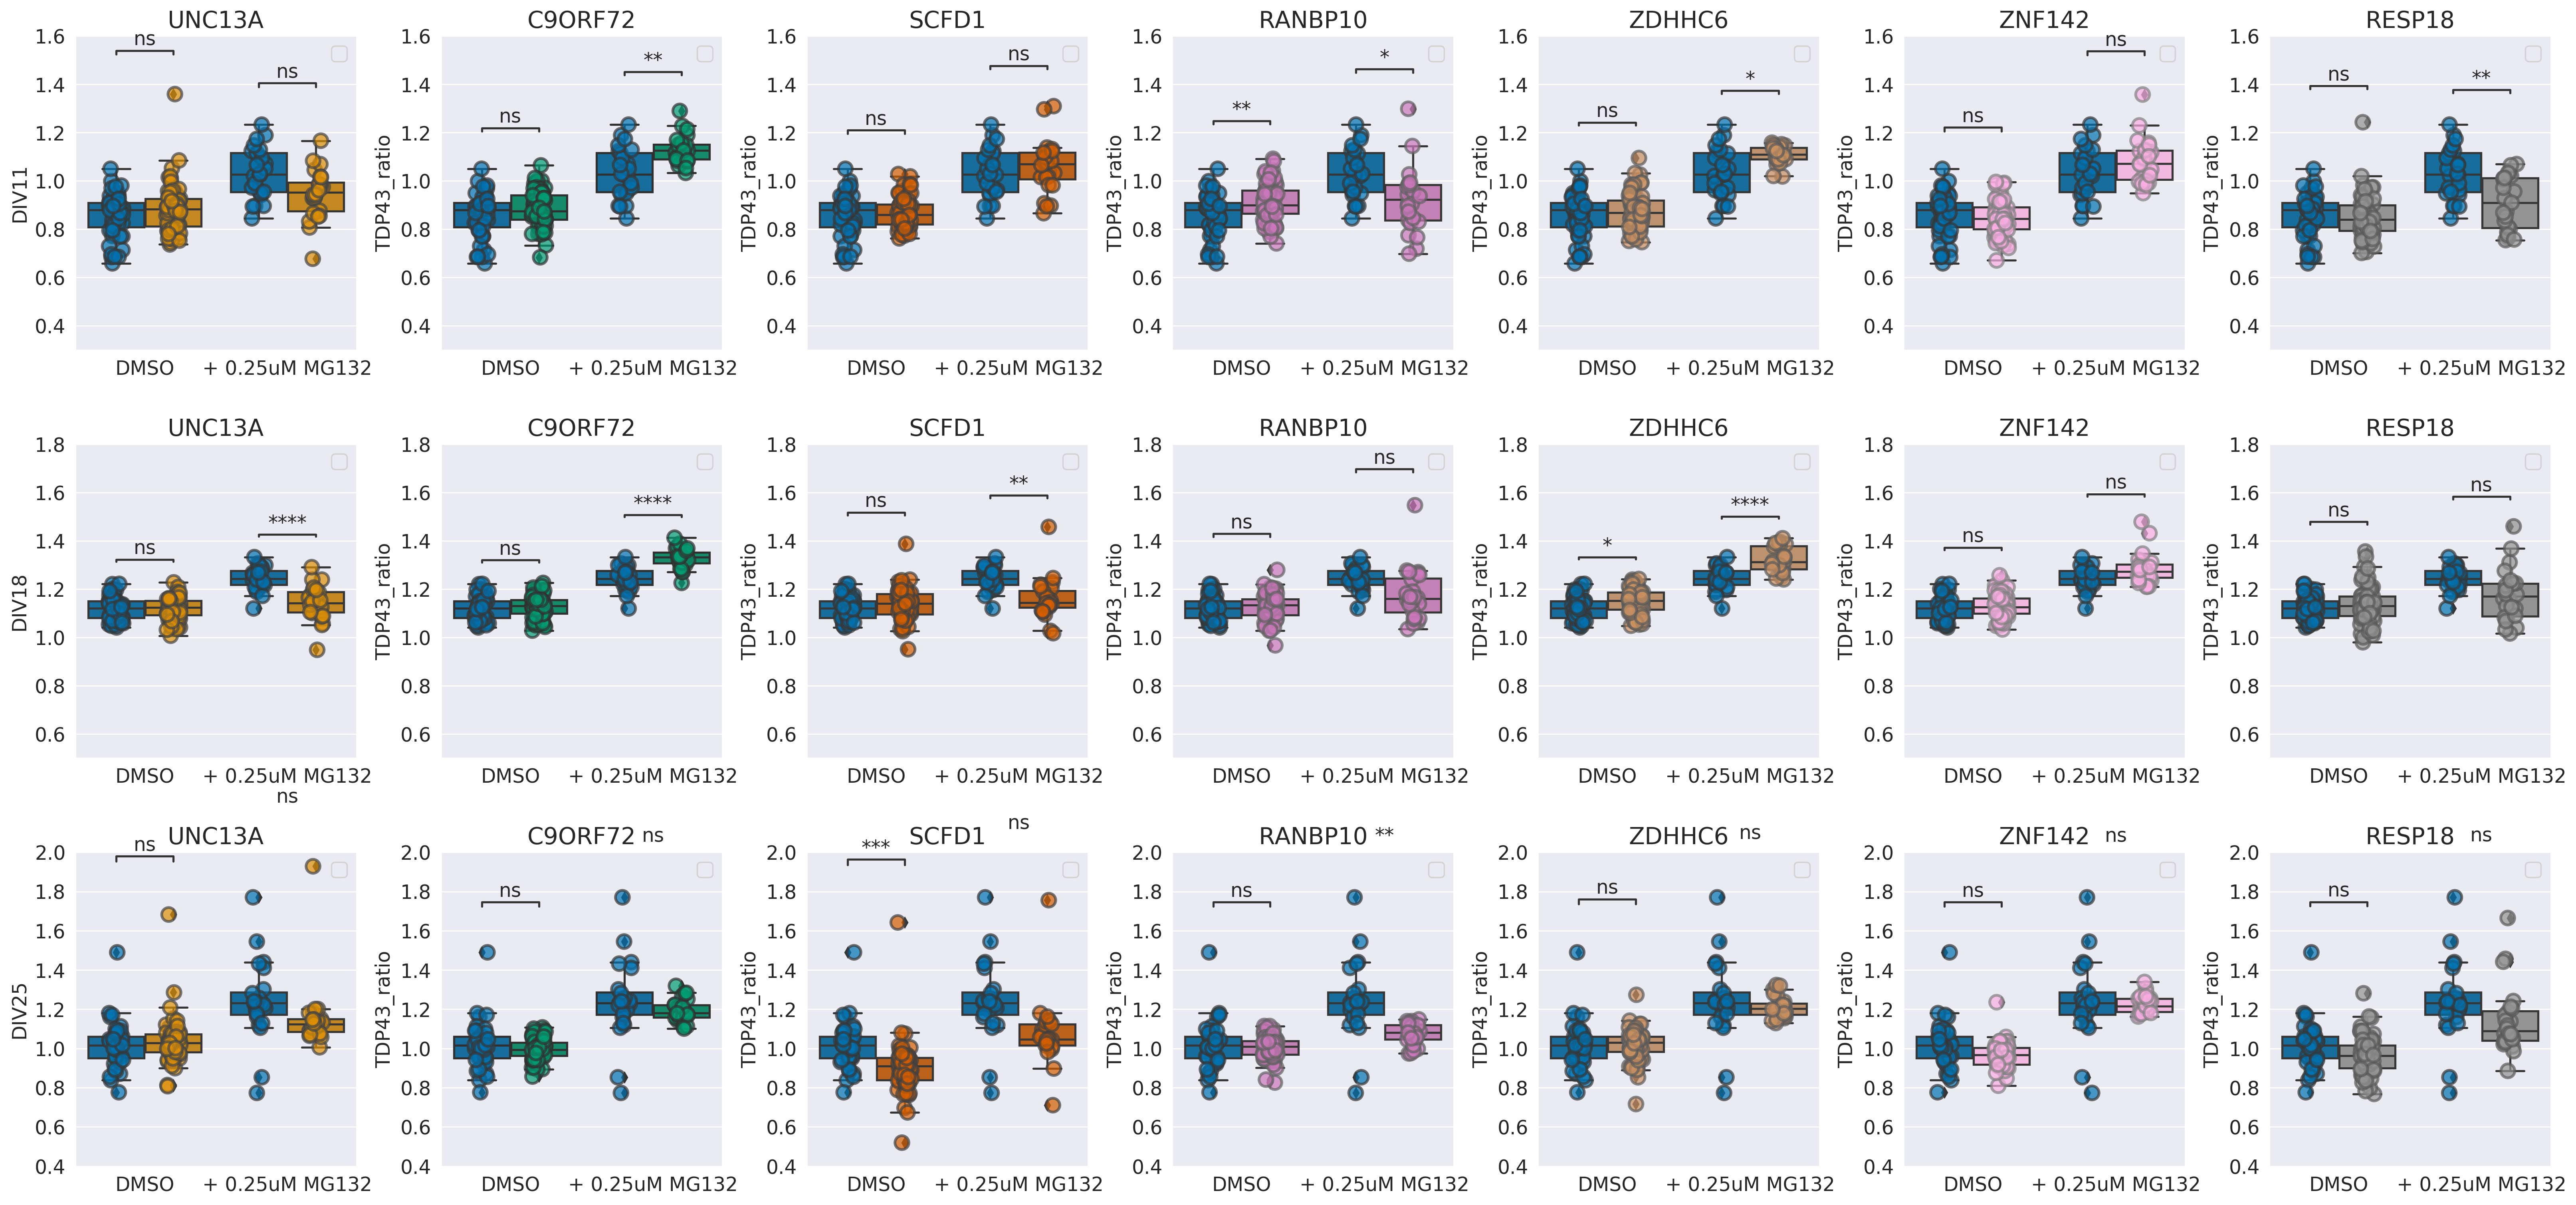

In [47]:
dirs = [Path('/lab/processed-data/ALS0006_NGN2_DIV11_KOv1_MG132/DIV11__2023-02-15T11_31_26-Measurement 1'),
    Path('/lab/processed-data/ALS0006_NGN2_DIV18_KOv1_MG132/DIV18__2023-02-24T08_47_12-Measurement 1'),
    Path('/lab/processed-data/ALS0006_KO01_TDP43_20X/ALS0006_KO01_TDP43_20X_01__2023-03-08T11_11_56-Measurement 1/')]
analysis_name = '2023-02-17_tdp43seg_tdp-43'
measurement = 'Intensity_IntegratedIntensity_TDP43_corrected'
neg_con = 'NT'
concentration = "0.25"

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (32, 15)
plt.rcParams['font.size'] = 14
NT_color = sns.color_palette('colorblind')[0]
ylims = [[0.3, 1.6], [0.5, 1.8], [0.4, 2]]
crispr_mutants = ratio_data.query('crispr not in["empty", @neg_con]')['crispr'].unique()
# crispr_mutants = ['UNC13A', 'C9ORF72', 'SCFD1', 'RANBP10', 'ZDHHC6', 'ZNF142',
    #    'RESP18']
fig, axs = plt.subplots(3, len(crispr_mutants))

for i_exp, data_dir in enumerate(dirs):
    plate = Plate(data_dir, analysis_name)
    ratio_data = calculate_ratio(plate, measurement)
    ratio_data = ratio_data.merge(plate.platemap, on='well_position')
    ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
    # ratio_data = ratio_data.groupby(['well_position', 'crispr', 'treatment', 'concentration']).mean()
    ratio_data = ratio_data.reset_index()
    ratio_data = ratio_data.drop(ratio_data.index[ratio_data['TDP43_ratio'] > 2])

    # pairs = [[(('0', 'NT'), ('0', crispr)), (('2', 'NT'), ('2', crispr))][0] for crispr in crispr_mutants]
    for i_crispr, crispr in enumerate(crispr_mutants):

        data = ratio_data.query('crispr in [@neg_con, @crispr] and concentration in ["0", @concentration]')
        hue = 'crispr'
        x = 'concentration'
        y = 'TDP43_ratio'
        ax = axs[i_exp,i_crispr]
        crispr_color = sns.color_palette('colorblind')[i_crispr+1]
        hue_order = ['NT', crispr]
        sns.boxplot(ax=ax,data=data, x=x, y=y, hue=hue, hue_order=hue_order, palette=[NT_color, crispr_color])
        sns.stripplot(ax=ax,data=data, x=x, y=y, hue=hue,  hue_order=hue_order, dodge=True, linewidth=2, size=10, palette=[NT_color, crispr_color], alpha=0.7)
        ax.set_xticklabels(['DMSO', '+ ' + concentration + 'uM MG132'])
        ax.set_xlabel('')
        ax.legend([])
        ax.set_title(crispr)

        pairs = [(('0', neg_con), ('0', crispr)), ((concentration, neg_con), (concentration, crispr))]
        annot = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue)
        annot.configure(test='t-test_ind', text_format='star',  comparisons_correction='bonferroni')
        annot.apply_test(num_comparisons=len(crispr_mutants)*2)
        ax, test_results = annot.annotate(line_offset_to_group=0.2)
        ax.set_ylim(ylims[i_exp])

plt.subplots_adjust(wspace=0.3, hspace=0.3)
axs[0,0].set_ylabel('DIV11')
axs[1,0].set_ylabel('DIV18')
axs[2,0].set_ylabel('DIV25')

In [35]:
data_dir = dirs[2]
plate = Plate(data_dir, analysis_name)
ratio_data = calculate_ratio(plate, measurement)
ratio_data = ratio_data.merge(plate.platemap, on='well_position')
ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
# ratio_data = ratio_data.groupby(['well_position', 'crispr', 'treatment', 'concentration']).mean()
ratio_data = ratio_data.reset_index()
# ratio_data.to_csv(data_dir / analysis_name / ('ALS0006_DIV11_' + analysis_name + '_ratio_data.csv'))

/tmp/ipykernel_3365/3166874526.py:5: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()


/tmp/ipykernel_3365/3356663746.py:21: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
/home/ubuntu/miniconda3/envs/cell-imaging-2/lib/python3.8/site-packages/seaborn/categorical.py:761: UserWarning: Attempting to set identical left == right == -0.5 results in singular transformations; automatically expanding.
  ax.set_xlim(-.5, len(self.plot_data) - .5, auto=None)
No handles with labels found to put in legend.
/tmp/ipykernel_3365/3356663746.py:38: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.stripplot(ax=ax,data=data, x=x, y=y, hue=hue,  hue_order=hue_order, dodge=True, linewidth=2, size=10, palette=[NT_color, crispr_color], alpha=0.7)
/tmp/ipykernel_3365/3356663746.py

TypeError: object of type 'NoneType' has no len()

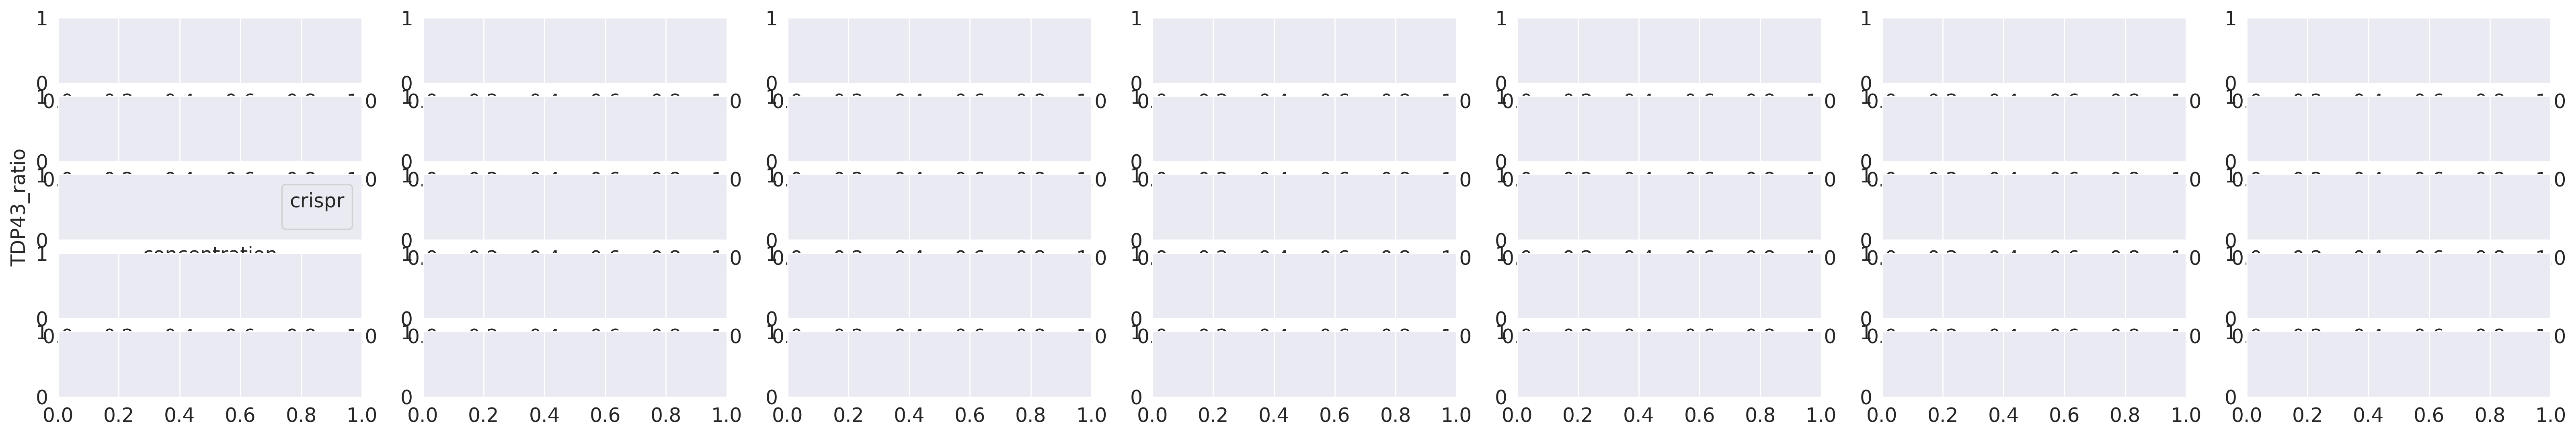

In [72]:
dirs = [Path('/lab/processed-data/TDP43_ALS0009_DIV18_KO_MG132/TDP43_ALS0009_KO1_DIV18_v1__2023-03-14T10_55_23-Measurement 1'),
    Path('/lab/processed-data/TDP43_ALS0013_DIV11_KO_MG132/DIV11 v1__2023-03-15T09_33_32-Measurement 1/')]
analysis_name = '2023-02-17_tdp43seg_tdp-43'
measurement = 'Intensity_IntegratedIntensity_TDP43_corrected'
neg_con = 'Non-Targeting'
concentration = "2"

sns.set_style('darkgrid')
plt.rcParams['figure.figsize'] = (32, 5)
plt.rcParams['font.size'] = 14
NT_color = sns.color_palette('colorblind')[0]
ylims = [[0.3, 1.6], [0.5, 1.8], [0.4, 2]]
# crispr_mutants = ['UNC13A', 'C9ORF72', 'SCFD1', 'RANBP10', 'ZDHHC6', 'ZNF142',
    #    'RESP18']
fig, axs = plt.subplots(5, len(crispr_mutants))

data_dir = dirs[1]
plate = Plate(data_dir, analysis_name)
ratio_data = calculate_ratio(plate, measurement)
ratio_data = ratio_data.merge(plate.platemap, on='well_position')
ratio_data = ratio_data.groupby(['FileName_TDP43', 'crispr', 'treatment', 'concentration']).mean()
# ratio_data = ratio_data.groupby(['well_position', 'crispr', 'treatment', 'concentration']).mean()
ratio_data = ratio_data.reset_index()
ratio_data = ratio_data.drop(ratio_data.index[ratio_data['TDP43_ratio'] > 2])
crispr_mutants = ratio_data.query('crispr not in["empty", "No Nucleofection", @neg_con]')['crispr'].unique()

# pairs = [[(('0', 'NT'), ('0', crispr)), (('2', 'NT'), ('2', crispr))][0] for crispr in crispr_mutants]
for i_crispr, crispr in enumerate(crispr_mutants):

    data = ratio_data.query('crispr in [@neg_con, @crispr] and concentration in ["0", @concentration]')
    hue = 'crispr'
    x = 'concentration'
    y = 'TDP43_ratio'
    ax = axs[i_exp,i_crispr]
    crispr_color = sns.color_palette('colorblind')[i_crispr+1]
    hue_order = [neg_con, crispr]
    sns.boxplot(ax=ax,data=data, x=x, y=y, hue=hue, hue_order=hue_order, palette=[NT_color, crispr_color])
    sns.stripplot(ax=ax,data=data, x=x, y=y, hue=hue,  hue_order=hue_order, dodge=True, linewidth=2, size=10, palette=[NT_color, crispr_color], alpha=0.7)
    ax.set_xticklabels(['DMSO', '+ ' + concentration + 'uM MG132'])
    ax.set_xlabel('')
    ax.legend([])
    ax.set_title(crispr)

    pairs = [(('0', neg_con), ('0', crispr)), ((concentration, neg_con), (concentration, crispr))]
    annot = Annotator(ax, pairs, data=data, x=x, y=y, hue=hue)
    annot.configure(test='t-test_ind', text_format='star',  comparisons_correction='bonferroni')
    annot.apply_test(num_comparisons=len(crispr_mutants)*2)
    ax, test_results = annot.annotate(line_offset_to_group=0.2)
    ax.set_ylim(ylims[i_exp])

plt.subplots_adjust(wspace=0.3, hspace=0.3)
axs[0,0].set_ylabel('DIV11')
axs[1,0].set_ylabel('DIV18')
axs[2,0].set_ylabel('DIV25')

In [38]:
ratio_data['TDP43_ratio'].std()

1.1269523688090746

In [44]:
ratio_data['concentration'].unique()

array(['empty', '0', '2', '0.5', '0.25'], dtype=object)

In [51]:
ratio_data['crispr'].unique()

array(['No Nucleofection', 'Non-Targeting', 'ALG8', 'AP3B2', 'BAG6',
       'C2CD4A', 'CAMLG', 'CLCN3', 'COG3'], dtype=object)

In [73]:
ratio_data.query('crispr in [@neg_con, @crispr] and concentration in ["0", @concentration]')

Empty DataFrame
Columns: [FileName_TDP43, crispr, treatment, concentration, row, col, TDP43_nucleus, TDP43_cytoplasm, TDP43_ratio, QC]
Index: []

In [74]:
ratio_data['concentration'].unique()

array(['empty'], dtype=object)

In [61]:
neg_con

'Non-Targeting'

In [62]:
crispr

'ALG8'